In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from theano import shared
%matplotlib inline
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import regex as re
from collections import defaultdict


In [3]:
df = pd.read_csv('../other/frac_merge_peak.csv')


In [4]:
df.columns


Index([u'PropID', u'RSID', u'End_Date', u'Reservoir', u'Completed_Feet',
       u'#_of_Stages', u'Stage_Length', u'Clusters/Stage', u'Cluster_Spacing',
       u'Perfs/Cluster', u'Fluid_Bbls', u'Fluid_Gal/Ft', u'Fluid_Gal/Cluster',
       u'Fluid_Gal/Perf', u'Prop_Lbs', u'Prop_Lbs/Ft', u'Prop_Lbs/Cluster',
       u'Prop_Lbs/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Avg_Rate',
       u'Max_Rate', u'Rate/Ft', u'Rate/Cluster', u'Rate/Perf', u'Avg_Pressure',
       u'Max_Pressure', u'ISIP/Ft', u'5"_SIP/Ft', u'PROPNUM', u'XEC_FIELD',
       u'OPERATOR', u'COUNTY', u'STATE', u'M_LATITUDE', u'M_LONGITUDE',
       u'MAJOR', u'SPUD_DATE', u'FIRST_PROD', u'Wet_Gas_EUR', u'Dry_Gas_EUR',
       u'Oil_EUR', u'NGL_EUR', u'Days_Production', u'OIL_Peak',
       u'OIL_Days_to_Peak'],
      dtype='object')

In [6]:
X = df[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', 
        u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Cluster_Spacing', u'Avg_Pressure', u'Prop_Lbs/Ft', 
        u'Prop_Lbs/Perf', u'Max_Pressure', u'Fluid_Gal/Perf', u'Fluid_Gal/Ft', u'Prop_Lbs/Cluster', 
        u'Fluid_Gal/Cluster']]
y = df[[u'OIL_Peak']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape


(133, 19)

In [7]:
def standardize_2sd(df):
    return (df - df.mean(0)) / (2 * df.std(0))

def standardize_2sd_test(df_test, df_train):
    return (df_test - df_train.mean(0)) / (2 * df_train.std(0))


In [10]:
X_lasso_train = X_train[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_train_std = standardize_2sd(X_lasso_train)
model = LinearRegression(fit_intercept=True, normalize=False)
model.fit(X_lasso_train_std, y_train)
print 'Train R2: {0}'.format(model.score(X_lasso_train_std, y_train))
X_lasso_test = X_test[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']]
X_lasso_test_std = standardize_2sd_test(X_lasso_test, X_lasso_train)
print 'Test R2: {0}'.format(model.score(X_lasso_test_std, y_test))


Train R2: 0.506618464039
Test R2: 0.188315827225


In [11]:
def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')
        
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm
        
def custom_forestplot(df, ylabel='field', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''
        
    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)
    

In [12]:
run_pooled = True

In [13]:
data = dict(x=X_lasso_train_std, y=y_train)

with pm.Model() as mdl_pooled:
    pm.glm.glm('y ~ x', data, family=pm.glm.families.Normal())
    if run_pooled:
        trc_pooled = pm.backends.text.load('../other/traces_txt/trc_pooled')
    else:
        step = pm.NUTS()
        start = pm.find_MAP()
        trace = pm.backends.Text('../other/traces_txt/trc_pooled')
        trc_pooled = pm.sample(2000, njobs=1, step=step, start=start, trace=trace)    
    

Applied log-transform to sd and added transformed sd_log_ to model.


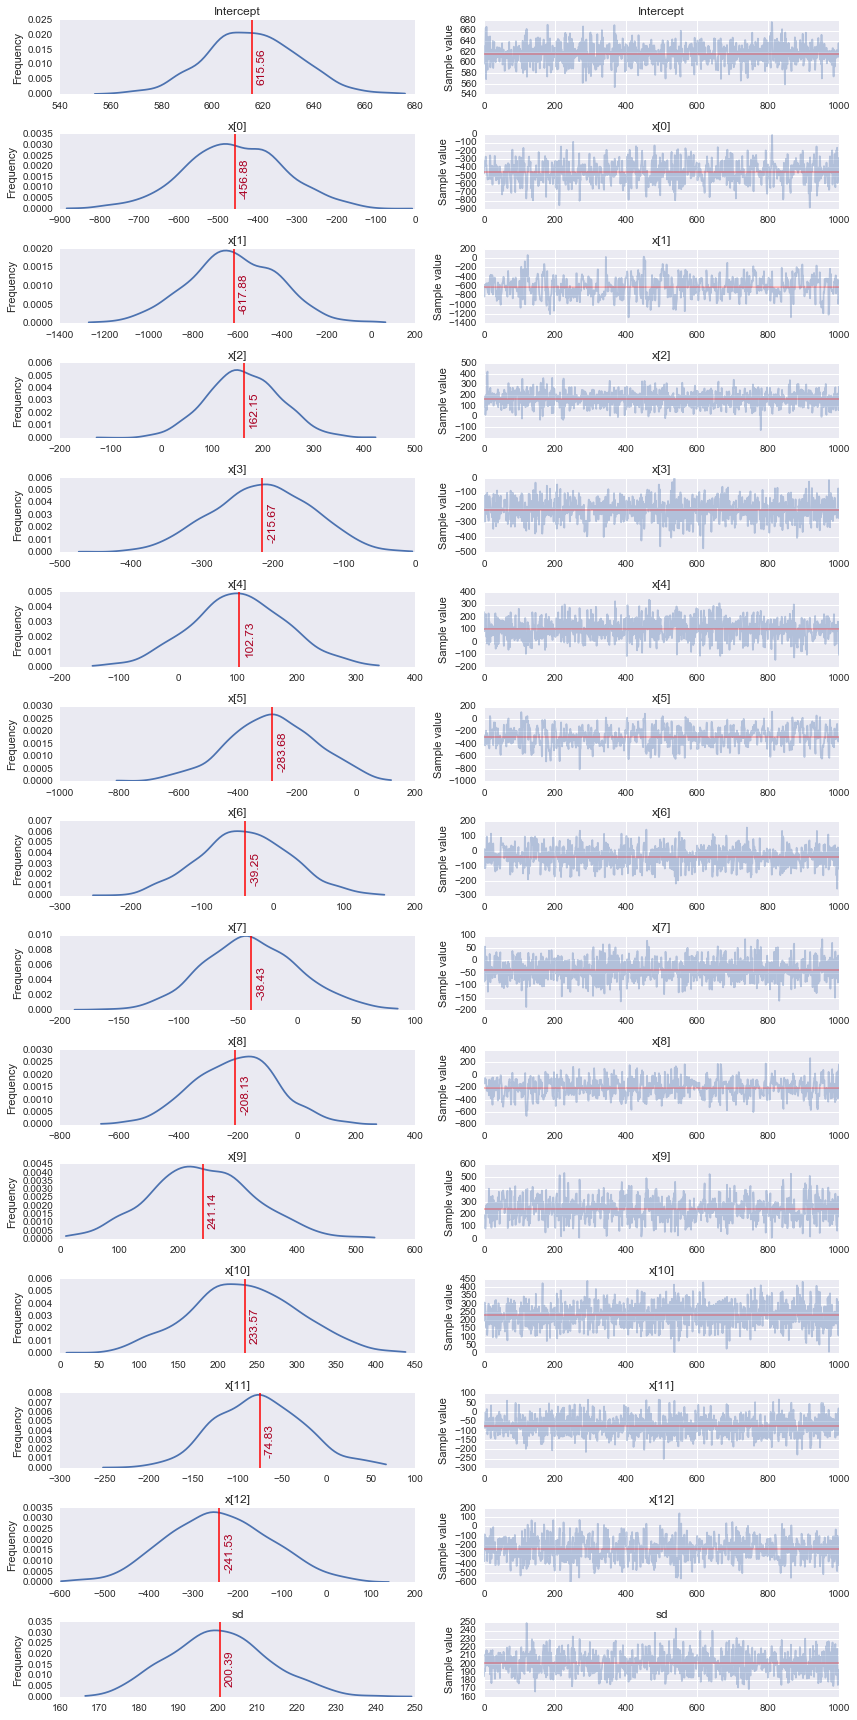

In [14]:
plot_traces(trc_pooled, retain=1000)


In [15]:
pm.df_summary(trc_pooled[-1000:])


,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,615.556979,18.422715,0.571114,579.553001,651.162451
x[0],-456.878708,125.837688,5.331533,-682.630181,-185.286957
x[1],-617.878500,206.651375,10.578001,-1023.913370,-237.567767
x[2],162.151039,71.912031,2.199659,31.893312,306.325930
x[3],-215.668699,70.746106,2.404054,-354.978286,-86.030621
x[4],102.729921,80.449771,2.669005,-49.543525,266.405664
x[5],-283.677622,147.340869,7.530281,-562.916912,8.554279
x[6],-39.249234,63.240693,2.538733,-177.713890,71.797831
x[7],-38.430143,40.746409,1.178745,-118.219088,39.234025
x[8],-208.131234,141.322192,6.219597,-489.987392,49.372779


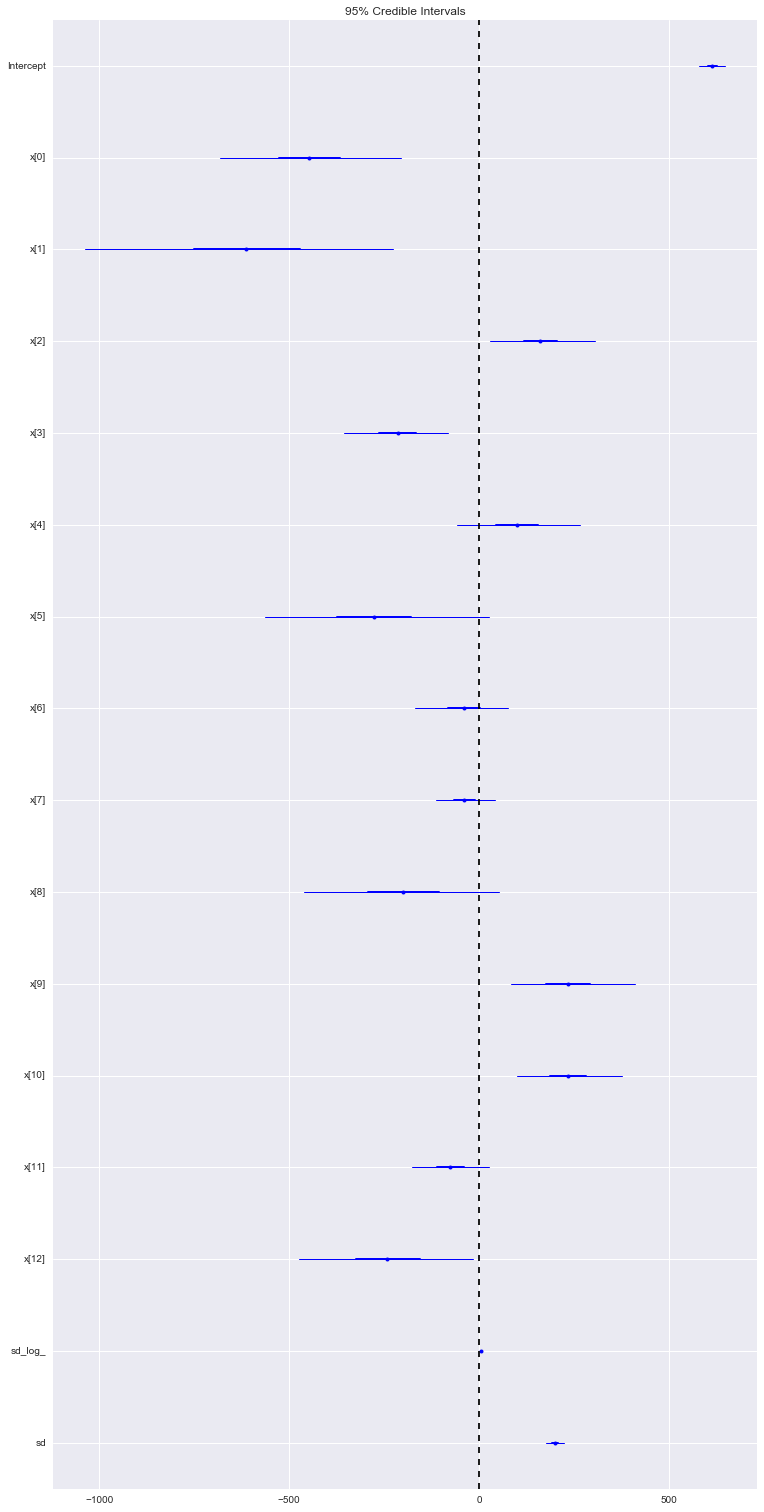

In [16]:
plt.figure(figsize=(12, 24))
pm.forestplot(trc_pooled)
# plt.savefig('../../Downloads/forestplot.png', dpi=400)
# plt.xlim(-1000, 1000)


In [19]:
ppc_pooled = pm.sample_ppc(trc_pooled[-1000:], samples=500, model=mdl_pooled, size=50)
y_pred = ppc_pooled['y'].mean(0).mean(0).T
waic_pooled = pm.stats.waic(model=mdl_pooled, trace=trc_pooled[-1000:])
print 'Train_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_train, y_pred1)))
print 'Train_R2: {0}'.format(r2_score(y_train, y_pred1))
print 'Train_WAIC: {0}'.format(waic_pooled)


Train_RMSE: 188.579840057
Train_R2: 0.506442750239
Train_WAIC: 1806.96252333


(0, 1200)

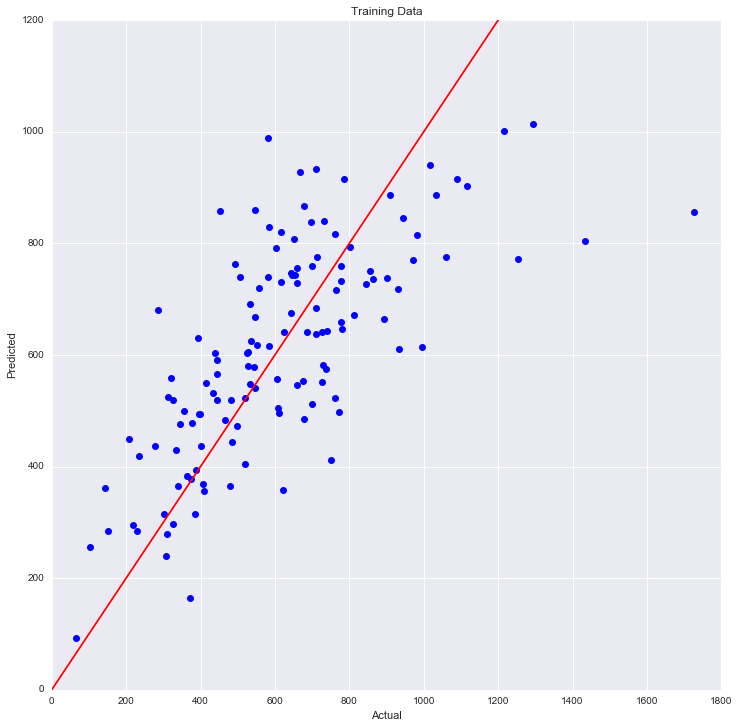

In [20]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_train, y_pred, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_title('Training Data')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])



In [21]:
parm_pooled = pm.df_summary(trc_pooled[-1000:]).values

In [22]:
y_pred_test = parm_pooled[0,0] + np.dot(X_lasso_test_std.values, parm_pooled[1:-1,0])

In [23]:
print 'Test_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test)))
print 'Test_R2: {0}'.format(r2_score(y_test, y_pred_test))

Test_RMSE: 199.638940639
Test_R2: 0.180450879786


(0, 1200)

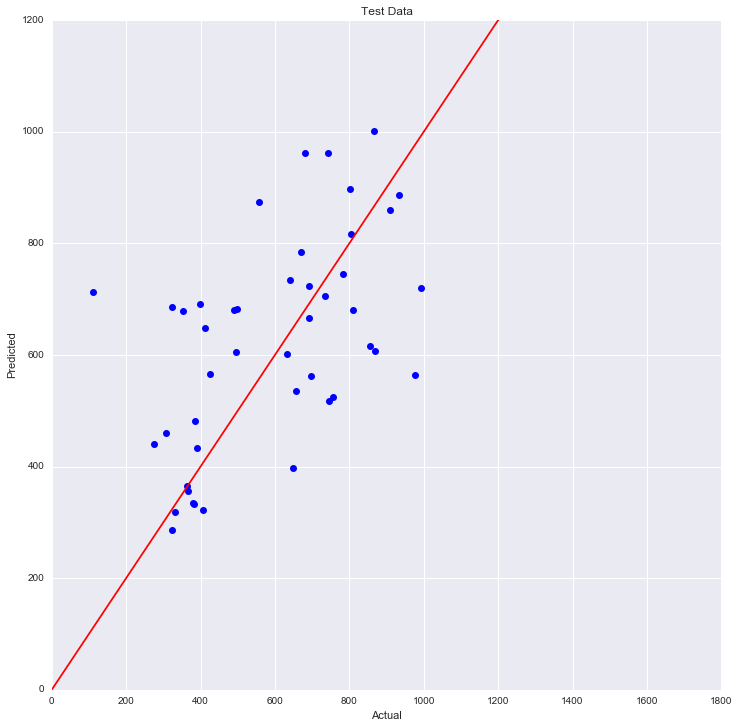

In [24]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.plot(y_test, y_pred_test, 'ko', color='blue')
ax.plot([0, 1800], [0,1800], color = 'red')
ax.set_title('Test Data')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_xlim([0, 1800])
ax.set_ylim([0, 1200])

In [107]:
def coeff(trc_pooled, df):
    coeff = pd.DataFrame()
    for name in [rv.name for rv in mdl_pooled.unobserved_RVs[:-2]]:
        coeff = pd.concat((coeff, pd.Series(trc_pooled[-500:][name])), axis=1)
    coeff.columns = ['b0'] + [col for col in X_lasso_train.columns]
    return coeff


In [144]:
df_coeff = coeff(trc_pooled, X_lasso_train)

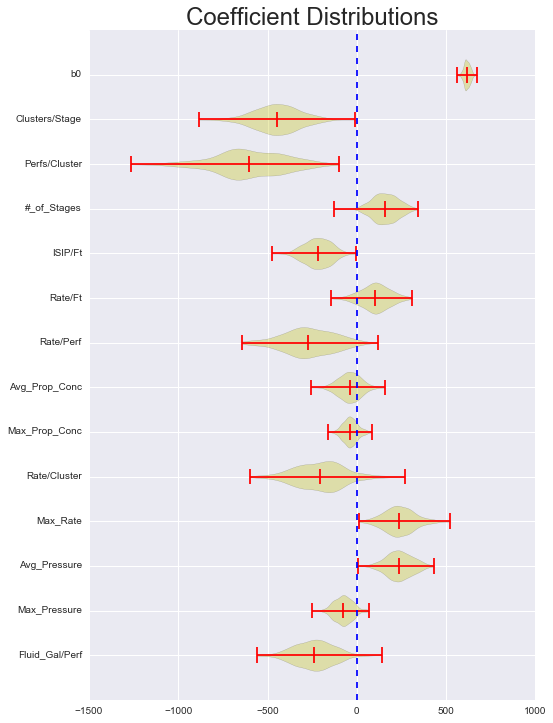

In [214]:
pos = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14]
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
ax.violinplot(df_coeff.values, pos, points=80, vert=False, widths=0.7, showmeans=True, showextrema=True, 
              showmedians=False)
ax.set_title('Coefficient Distributions', fontsize=24)
ax.set_yticks(pos)
ax.set_yticklabels([col for col in df_coeff.columns])
ax.set_ylim([-15, 0])
plt.axvline(x=0, color='blue', linestyle='--')
# plt.savefig('../other/figures/coeff_pooled', dpi=400)

In [185]:
y_pred_dist = ppc_pooled['y'].mean(1).mean(1)

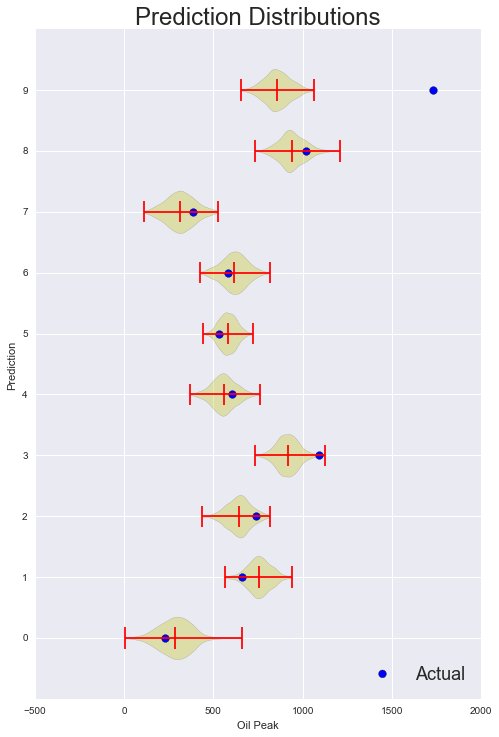

In [217]:
pos = range(10)
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
ax.violinplot(y_pred_dist[:,:10], pos, points=80, vert=False, widths=0.7, showmeans=True, showextrema=True, 
              showmedians=False)
ax.scatter(y_train[:10], pos, s=60, label='Actual')
ax.set_title('Prediction Distributions', fontsize=24)
ax.set_yticks(pos)
ax.set_ylim([-1, 10])
ax.set_xlabel('Oil Peak')
ax.set_ylabel('Prediction')
plt.legend(fontsize=18, loc='lower right')
# plt.savefig('../other/figures/pred_pooled', dpi=400)

In [194]:
len(y_pred_dist[:10,:])

10